# 1. let's read the occurence data from this paper: https://www.nature.com/articles/s41598-019-45491-7#Sec7
#they have data for Mexico and Guatemala, as well as other countries in central america 

In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 1. Load your Excel data
df = pd.read_excel("/Users/szelie/data/unu/occurrence_data-1.xlsx", sheet_name='Data')

# 2. Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")



/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_33260/2299449603.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


there are a bunch of species:

In [34]:
np.unique(gdf.species)

array(['Acacia hindsii', 'Acacia pennatula', 'Acacia picachensis',
       'Acosmium panamense', 'Albizia guachapele', 'Albizia saman',
       'Anacardium excelsum', 'Anacardium occidentale', 'Andira inermis',
       'Annona cherimola', 'Annona muricata', 'Annona purpurea',
       'Annona reticulata', 'Annona squamosa', 'Artocarpus altilis',
       'Astronium graveolens', 'Bactris gasipaes', 'Brosimum alicastrum',
       'Bursera simaruba', 'Byrsonima crassifolia',
       'Calophyllum brasiliense', 'Calycophyllum candidissimum',
       'Carapa guianensis', 'Cassia grandis', 'Cecropia obtusifolia',
       'Cecropia peltata', 'Cedrela odorata', 'Ceiba pentandra',
       'Chrysophyllum cainito', 'Chrysophyllum mexicanum',
       'Chrysophyllum oliviforme', 'Citrus limon', 'Citrus reticulata',
       'Citrus sinensis', 'Citrus\xa0aurantiifolia', 'Coffea arabica',
       'Cordia alliodora', 'Dalbergia glomerata', 'Diphysa americana',
       'Enterolobium cyclocarpum', 'Erythrina berteroana',

# load countries:
this was useful to select mexico and guatemala but after there is too little data to train the model

In [107]:
# 3. Load world country boundaries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# 4. Spatial join to assign countries
gdf_with_country = gpd.sjoin(gdf, world, how="inner", predicate="within")

# 5. Filter only Mexico and Guatemala
#gdf_filtered = gdf_with_country[gdf_with_country['name'].isin(['Mexico', 'Guatemala'])]

# 6. Drop duplicates and unnecessary columns
gdf_with_country = gdf_with_country.drop_duplicates(subset=['lon', 'lat'])
gdf_maxent = gdf_with_country[['lon', 'lat', 'species', 'geometry']]

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_33260/3719946820.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [56]:
gdf_maxent_coffee_cacao = gdf_maxent[(gdf_maxent.species=='Coffea arabica')|(gdf_maxent.species=='Theobroma cacao')]

In [66]:
gdf_maxent_coffee_cacao = gdf_maxent_coffee_cacao[(gdf_maxent_coffee_cacao.lon<-20)&(gdf_maxent_coffee_cacao.lat>0)]

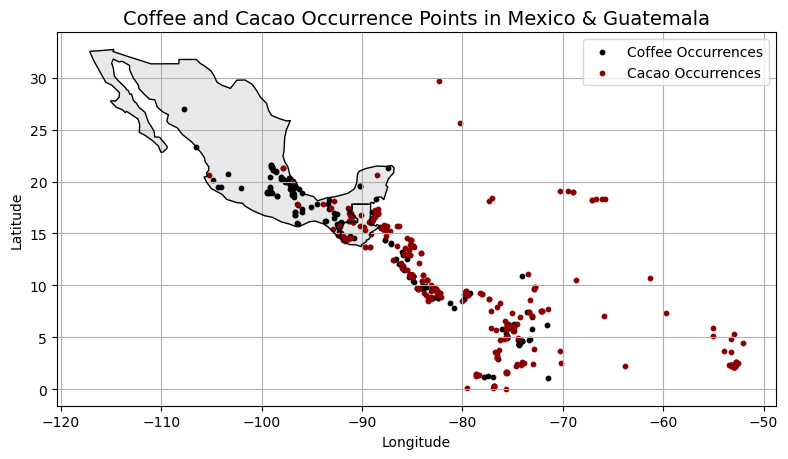

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

countries = world[world['name'].isin(['Mexico', 'Guatemala'])]

countries.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
countries.plot(ax=ax, facecolor='lightgrey', alpha=0.5)

gdf_maxent_coffee_cacao[gdf_maxent_coffee_cacao.species=='Coffea arabica'].plot(ax=ax, color='black', markersize=10, label='Coffee Occurrences')
gdf_maxent_coffee_cacao[gdf_maxent_coffee_cacao.species=='Theobroma cacao'].plot(ax=ax, color='darkred', markersize=10, label='Cacao Occurrences')

# Add some extras
ax.set_title("Coffee and Cacao Occurrence Points in Mexico & Guatemala", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
len(gdf_maxent_coffee_cacao[gdf_maxent_coffee_cacao.species=='Coffea arabica'])

179

In [72]:
gdf_maxent_coffee_cacao[['species','lon','lat']].to_csv("/Users/szelie/data/unu/occurrence_data.csv", index=False)

# Now we need some climatology data

the ecologists seem to like these woldclim datasets but they are based on climate up to the 1990s which I don't find great.
but anyways they are easy to use for a first try

I downloaded the data here: https://worldclim.org/data/worldclim21.html for historical and all variables on 2.5min resolution

let's see what they look like:


let's see what this data look like:

In [48]:
import rasterio
import numpy as np
from pathlib import Path

input_folder = Path("/Users/szelie/data/unu/wc2-2")
bio_vars = list(np.arange(1, 20))

for bio in bio_vars[0:3]:
    in_path = input_folder / f"wc2.1_2.5m_bio_{bio}.tif"
    
    with rasterio.open(in_path) as src:
        print(f"--- {in_path.name} ---")
        
        # Print the metadata
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("Resolution:", src.res)
        print("Width x Height:", src.width, "x", src.height)
        
        # Read some values
        data = src.read(1, masked=True)  # << this!
        print("Data type:", data.dtype)
        print("Min/Max values:", np.nanmin(data), "/", np.nanmax(data))
        print()


--- wc2.1_2.5m_bio_1.tif ---
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Resolution: (0.041666666666666664, 0.041666666666666664)
Width x Height: 8640 x 4320
Data type: float32
Min/Max values: -54.759167 / 31.166666

--- wc2.1_2.5m_bio_2.tif ---
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Resolution: (0.041666666666666664, 0.041666666666666664)
Width x Height: 8640 x 4320
Data type: float32
Min/Max values: 1.0 / 21.973

--- wc2.1_2.5m_bio_3.tif ---
CRS: EPSG:4326
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Resolution: (0.041666666666666664, 0.041666666666666664)
Width x Height: 8640 x 4320
Data type: float32
Min/Max values: 9.063088 / 100.0



so this is from this paper: https://www.nature.com/articles/s41598-019-45491-7#Sec7
"We selected the least correlated variables applying an analysis of variance-inflation factors (VIF)53, whereby the variables with the highest correlation (VIF > 10) were removed, resulting in nine bioclimatic predictors. Which were: (i) bio02, mean diurnal range; (ii) bio03, isothermality; (iii) bio08, mean temperature of wettest quarter; (iv) bio09, mean temperature of driest quarter, (v) bio13, precipitation of wettest month; (vi) bio14, precipitation of driest month; (vii) bio15, precipitation seasonality; (viii) bio18, precipitation of warmest quarter; and, (ix) bio19, precipitation of coldest quarter."
based on that I also looked at these variables


they need to be saved to .asc and also I select the bounding box over central america

In [71]:
import rasterio
import numpy as np
from pathlib import Path
from rasterio.windows import from_bounds

# 🔁 Input and output folders
input_folder = Path("/Users/szelie/data/unu/wc2-2")      # where your .tif files are
output_folder = Path("/Users/szelie/data/unu/bioclim_asc_subset/")  # new folder
output_folder.mkdir(exist_ok=True)

# Bounding box for Central America
bbox = {
    "min_lon": -120,
    "min_lat": 0,
    "max_lon": -50,
    "max_lat": 32
}

# Bioclim variable names selected based on paper
bio_names = {
    2: "Mean_Diurnal_Range",
    3: "Isothermality",
    8: "Mean_Temp_Wettest_Quarter",
    9: "Mean_Temp_Driest_Quarter",
    13: "Precip_Wettest_Month",
    14: "Precip_Driest_Month",
    15: "Precip_Seasonality",
    18: "Precip_Warmest_Quarter",
    19: "Precip_Coldest_Quarter"
}

bio_vars = list(bio_names.keys())  # use all

for bio in bio_vars:
    in_path = input_folder / f"wc2.1_2.5m_bio_{bio}.tif"
    out_path = output_folder / f"{bio_names[bio]}.asc"
    
    with rasterio.open(in_path) as src:
        window = from_bounds(bbox["min_lon"], bbox["min_lat"], bbox["max_lon"], bbox["max_lat"], src.transform)
        transform = src.window_transform(window)
        
        profile = src.profile
        profile.update({
            "height": window.height,
            "width": window.width,
            "transform": transform,
            "driver": "AAIGrid",  # ESRI ASCII format
            "nodata": -9999
        })

        # Read and mask invalid values
        data = src.read(1, window=window, masked=True)
        data = data.filled(-9999)  # Fill masked values with -9999 for MaxEnt

        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(data, 1)

print("✅ All selected rasters cropped, renamed, cleaned and converted to .asc!")


✅ All selected rasters cropped, renamed, cleaned and converted to .asc!


so then based on this and the occurence data I run maxent, I downloaded the java version. after you oben the gui maxent.jar, browse to the occurence_data.csv for the samples, and to the directory containing the climatic variables for he environmental layer and click run

in the next cell we read in the results:


Columns in maxentResults.csv:
Index(['Species', '#Training samples', 'Regularized training gain',
       'Unregularized training gain', 'Iterations', 'Training AUC',
       '#Background points', 'Isothermality contribution',
       'Mean_Diurnal_Range contribution',
       'Mean_Temp_Driest_Quarter contribution',
       'Mean_Temp_Wettest_Quarter contribution',
       'Precip_Coldest_Quarter contribution',
       'Precip_Driest_Month contribution', 'Precip_Seasonality contribution',
       'Precip_Warmest_Quarter contribution',
       'Precip_Wettest_Month contribution',
       'Isothermality permutation importance',
       'Mean_Diurnal_Range permutation importance',
       'Mean_Temp_Driest_Quarter permutation importance',
       'Mean_Temp_Wettest_Quarter permutation importance',
       'Precip_Coldest_Quarter permutation importance',
       'Precip_Driest_Month permutation importance',
       'Precip_Seasonality permutation importance',
       'Precip_Warmest_Quarter permutation i

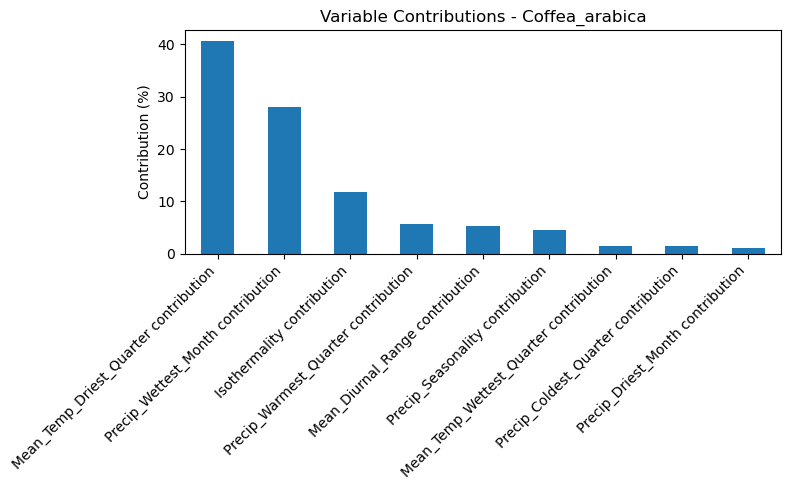


=== Analysis for Theobroma_cacao ===
Training samples: 262
Training AUC: 0.890
Regularized Training Gain: 1.194
Iterations: 500

Top contributing variables:
Precip_Wettest_Month contribution: 48.16%
Mean_Temp_Driest_Quarter contribution: 11.31%
Isothermality contribution: 9.11%
Precip_Warmest_Quarter contribution: 8.08%
Precip_Coldest_Quarter contribution: 7.17%
Precip_Seasonality contribution: 6.81%
Precip_Driest_Month contribution: 6.68%
Mean_Diurnal_Range contribution: 2.25%
Mean_Temp_Wettest_Quarter contribution: 0.42%


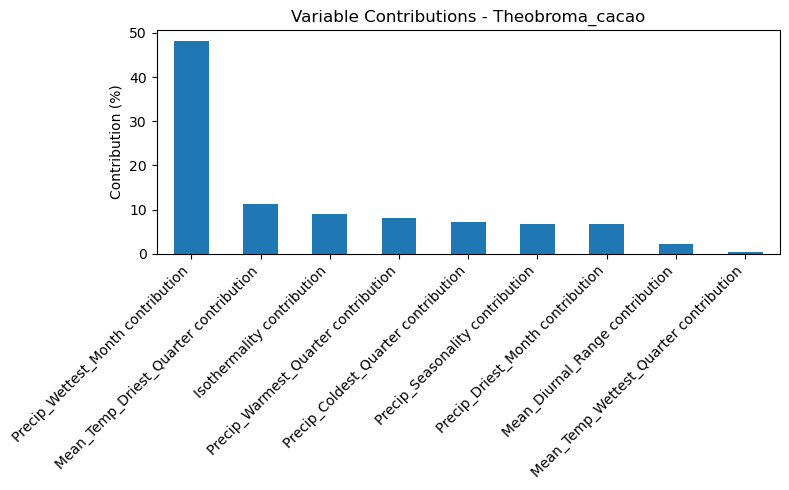


✅ MaxEnt results analysis complete!


In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Load MaxEnt results
file_path = '/Users/szelie/data/unu/maxentResults.csv'  # Update this path
results = pd.read_csv(file_path)

# Preview the file
print("\nColumns in maxentResults.csv:")
print(results.columns)

# List unique species
species_list = results['Species'].unique()
print("\nSpecies modeled:", species_list)

# Analyse each species separately
for species in species_list:
    print(f"\n=== Analysis for {species} ===")
    species_data = results[results['Species'] == species]

    # Get basic model info
    n_training_samples = species_data['#Training samples'].values[0]
    training_auc = species_data['Training AUC'].values[0]
    regularized_training_gain = species_data['Unregularized training gain'].values[0]
    iterations = species_data['Iterations'].values[0]

    print(f"Training samples: {n_training_samples}")
    print(f"Training AUC: {training_auc:.3f}")
    print(f"Regularized Training Gain: {regularized_training_gain:.3f}")
    print(f"Iterations: {iterations}")

    # Extract variable contributions
    variable_columns = [col for col in species_data.columns if col.endswith('contribution')]
    if variable_columns:
        contributions = species_data[variable_columns].iloc[0]
        contributions = contributions[contributions > 0].sort_values(ascending=False)

        if not contributions.empty:
            print("\nTop contributing variables:")
            for var, val in contributions.items():
                print(f"{var.replace('contribution.', '')}: {val:.2f}%")

            # Plot variable contributions
            plt.figure(figsize=(8,5))
            contributions.plot(kind='bar')
            plt.title(f"Variable Contributions - {species}")
            plt.ylabel("Contribution (%)")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("No variable contributions recorded.")
    else:
        print("No variable contribution columns found.")

print("\n✅ MaxEnt results analysis complete!")

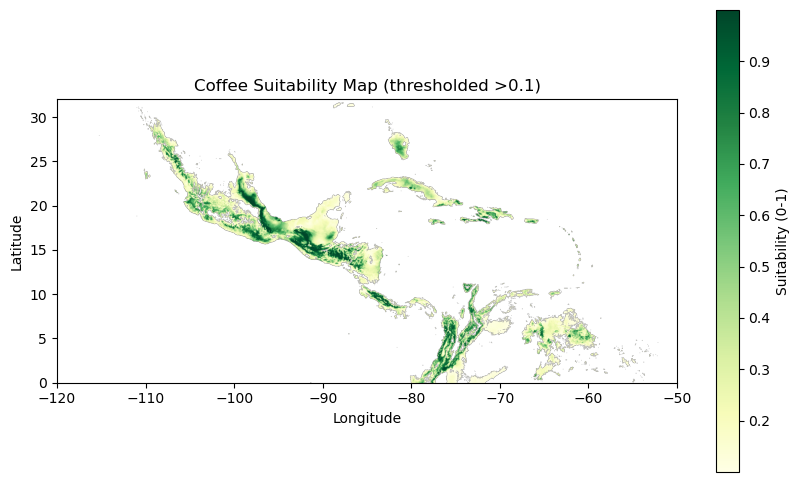

In [95]:
import rasterio
import matplotlib.pyplot as plt

# Path to your MaxEnt output .asc file
suitability_path = '/Users/szelie/data/unu/Coffea_arabica.asc'

# Open the raster
with rasterio.open(suitability_path) as src:
    suitability = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

suitability_masked = np.where(suitability > 0.1, suitability, np.nan)

plt.figure(figsize=(10, 6))
plt.imshow(suitability_masked, cmap='YlGn', extent=extent, origin='upper')
plt.colorbar(label='Suitability (0-1)')
plt.title('Coffee Suitability Map (thresholded >0.1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

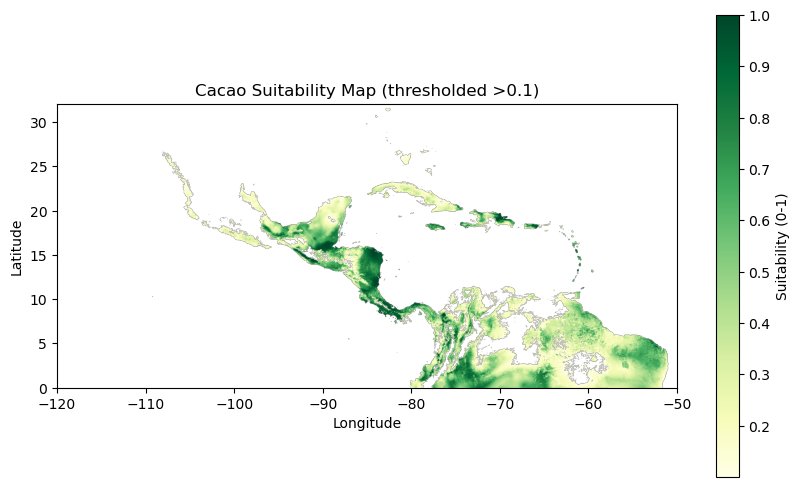

In [88]:
import rasterio
import matplotlib.pyplot as plt

# Path to your MaxEnt output .asc file
suitability_path = '/Users/szelie/data/unu/Theobroma_cacao.asc'

# Open the raster
with rasterio.open(suitability_path) as src:
    suitability = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

suitability_masked = np.where(suitability > 0.1, suitability, np.nan)

plt.figure(figsize=(10, 6))
plt.imshow(suitability_masked, cmap='YlGn', extent=extent, origin='upper')
plt.colorbar(label='Suitability (0-1)')
plt.title('Cacao Suitability Map (thresholded >0.1)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

here I am just changing some of the files based on some guess of what climate change could do (of course if we continue with that we would use actual climate models)

# Changes in Suitability due to climate change, simple assumption

In [99]:
import rasterio
import numpy as np
from pathlib import Path

# Your paths
input_folder = Path("/Users/szelie/data/unu/bioclim_asc_subset/")
output_folder = Path("/Users/szelie/data/unu/bioclim_asc_projection_2050/")
output_folder.mkdir(exist_ok=True)

# Variable names and modification assumptions
bio_modifications = {
    2: ("Mean_Diurnal_Range", 0.0),           # no change
    3: ("Isothermality", 0.0),                 # no change
    8: ("Mean_Temp_Wettest_Quarter", 2.0),     # +2°C
    9: ("Mean_Temp_Driest_Quarter", 2.0),      # +2°C
    13: ("Precip_Wettest_Month", -0.05),       # -5%
    14: ("Precip_Driest_Month", -0.10),        # -10%
    15: ("Precip_Seasonality", 0.05),          # +5%
    18: ("Precip_Warmest_Quarter", -0.05),     # -5%
    19: ("Precip_Coldest_Quarter", -0.05)      # -5%
}

# Process each raster
for bio_num, (var_name, change) in bio_modifications.items():
    input_path = input_folder / f"{var_name}.asc"
    output_path = output_folder / f"{var_name}.asc"

    with rasterio.open(input_path) as src:
        profile = src.profile
        data = src.read(1)

        # Handle nodata
        nodata = profile.get('nodata', -9999)
        mask = (data == nodata)

        # Apply modifications
        if "Temp" in var_name:
            # Temperature adjustment (+/- degrees Celsius)
            data_modified = data + change
        elif "Precip" in var_name:
            # Precipitation adjustment (% change)
            data_modified = data * (1 + change)
        else:
            # No modification
            data_modified = data

        # Restore nodata
        data_modified[mask] = nodata

    # Save modified raster
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(data_modified, 1)

print("✅ All rasters modified and saved for 2050 projection!")


✅ All rasters modified and saved for 2050 projection!


the Maxent gui has another field called projection layer that you can point to these new climatology datasets for 2050

and here is the output:

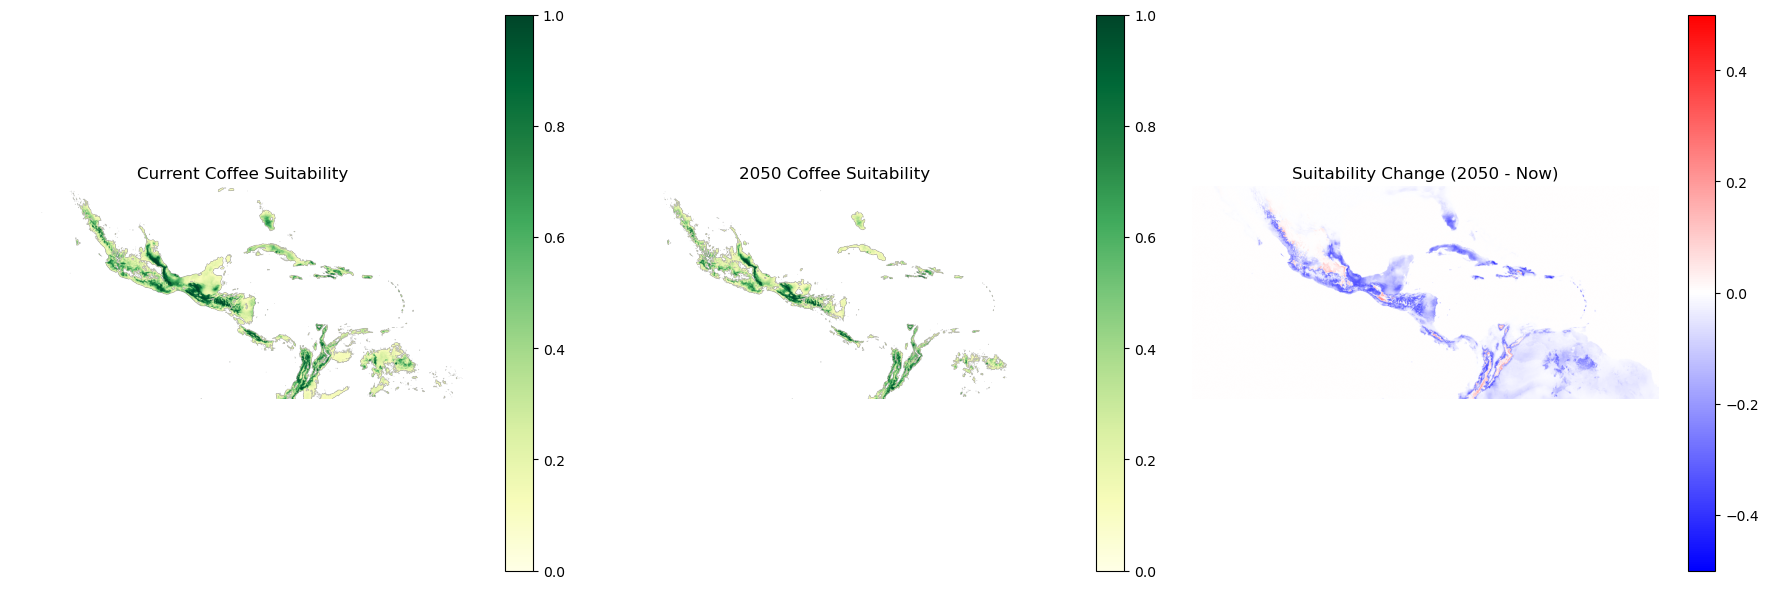

In [115]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Paths to your MaxEnt outputs
suitability_now_path = '/Users/szelie/data/unu/Coffea_arabica.asc'  # Current suitability
suitability_2050_path = '/Users/szelie/data/unu/Coffea_arabica_bioclim_asc_projection_2050.asc'  # Future suitability

# Open current suitability
with rasterio.open(suitability_now_path) as src:
    suitability_now = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Open future suitability
with rasterio.open(suitability_2050_path) as src:
    suitability_2050 = src.read(1)

# Mask low suitability (optional)
threshold = 0.1
suitability_now_masked = np.where(suitability_now >= threshold, suitability_now, np.nan)
suitability_2050_masked = np.where(suitability_2050 >= threshold, suitability_2050, np.nan)

# Difference
suitability_diff = suitability_2050 - suitability_now

# --- Plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Current
axs[0].imshow(np.full_like(suitability_now, np.nan), extent=extent, origin='upper', cmap='Greys', vmin=0, vmax=1)  # Grey background
im1 = axs[0].imshow(suitability_now_masked, cmap='YlGn', extent=extent, origin='upper', vmin=0, vmax=1)
axs[0].set_title('Current Coffee Suitability')
plt.colorbar(im1, ax=axs[0])

# Plot 2: 2050
axs[1].imshow(np.full_like(suitability_2050, np.nan), extent=extent, origin='upper', cmap='Greys', vmin=0, vmax=1)  # Grey background
im2 = axs[1].imshow(suitability_2050_masked, cmap='YlGn', extent=extent, origin='upper', vmin=0, vmax=1)
axs[1].set_title('2050 Coffee Suitability')
plt.colorbar(im2, ax=axs[1])

# Plot 3: Change
im3 = axs[2].imshow(suitability_diff, cmap='bwr', extent=extent, origin='upper', vmin=-0.5, vmax=0.5)
axs[2].set_title('Suitability Change (2050 - Now)')
plt.colorbar(im3, ax=axs[2])

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
